In [1]:
import copy
import json
import os
from typing import Callable, Dict, List, Optional, Tuple, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
import ujson
from scipy.sparse import csr_matrix
from scipy.spatial import Delaunay
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tiresias.metrics.mask_metrics import count_mask_pixels_in_radius
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import ARGVA, GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
from tqdm.notebook import tqdm

## Function from tiresias

In [2]:
def generate_graph_adj_matrix(
    dataset: pd.DataFrame,
    center_x_col_name: str = "center_x",
    center_y_col_name: str = "center_y",
    compute_edge_lengths: bool = True,
) -> csr_matrix:
    """Generates graph based on contour centroids and edge distance matrix. Nodes are ordered according to dataset row
    order, so mapping is one to one.
    :param dataset: pd.DataFrame, which contains coordinates of contour centroids
    and columns of features to add for each node in graph.
    :param center_x_col_name: name of column in dataset, which contains contour centroid x coordinate
    :param center_y_col_name: name of column in dataset, which contains contour centroid y coordinate
    :param compute_edge_lengths: compute length(L2) of connected nodes
    :return: CSR sparse adjacency matrix and optional edge lengths array
    """
    coordinates_columns_difference = {center_x_col_name, center_y_col_name}.difference(
        dataset.columns
    )
    if coordinates_columns_difference:
        raise KeyError(
            f"Centroid columns must be present in dataset, keys not found: {coordinates_columns_difference}"
        )

    n_points = dataset.shape[0]
    point_coordinates = dataset[[center_x_col_name, center_y_col_name]].values
    del_triangulation = Delaunay(point_coordinates, qhull_options="QJ")
    indptr, indices = del_triangulation.vertex_neighbor_vertices

    adjacency_matrix = csr_matrix(
        (
            np.ones_like(indices, dtype=np.int32),
            indices,
            indptr,
        ),  # Using ones to indicate edges, no self-loops
        shape=(n_points, n_points),
    )

    if compute_edge_lengths:
        adj_row_idx, adj_col_idx = adjacency_matrix.nonzero()

        edge_lengths = np.linalg.norm(
            point_coordinates[adj_row_idx] - point_coordinates[adj_col_idx],
            axis=1,
            keepdims=True,
        ).ravel()

        adjacency_matrix = csr_matrix(
            (
                edge_lengths,
                indices,
                indptr,
            ),
            shape=(n_points, n_points),
        )
        return adjacency_matrix

    return adjacency_matrix

In [3]:
def threshold_graph_edges_by_distance(
    adjacency_matrix: csr_matrix,
    distance_threshold: Union[int, float],
) -> csr_matrix:
    """
    Removes edges by distance threshold
    :param adjacency_matrix: graph sparse matrix with stored distances
    :param distance_threshold: threshold for cutoff
    """
    if not isinstance(adjacency_matrix, csr_matrix):
        raise ValueError(
            f"Adjacency matrix have to be scipy`s CSR matrix! Currently: {type(adjacency_matrix)}"
        )

    adjacency_matrix[adjacency_matrix > distance_threshold] = 0
    adjacency_matrix.eliminate_zeros()
    return adjacency_matrix

In [4]:
def calculate_edge_length_statistic(
    adjacency_matrix: csr_matrix,
    distance_treshold: float,
    stat_function: Callable[[np.array], float] = np.median,
):
    """
    Calculates node median distance to neighbours
    :param adjacency_matrix: Graph sparse matrix with stored distances
    :param distance_treshold: Default value for nods without neighbors
    :param stat_function: Statistic function
    :return: Aggregated statistic by edge
    """
    adj_row_idx, adj_col_idx = adjacency_matrix.nonzero()
    nonzero_data = np.array(adjacency_matrix[adj_row_idx, adj_col_idx].data).ravel()
    split_indexes = np.cumsum(np.bincount(adj_row_idx))[:-1]
    return np.array(
        [
            stat_function(x) if x.size else distance_treshold
            for x in np.split(nonzero_data, split_indexes)
        ]
    )

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=False)
        self.conv_mu = GCNConv(hidden_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(hidden_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class Discriminator(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

### Processing configuration

In [6]:
path_cells = '/uftp/IA_AI/NCI_Andrea_FL/Metrics/Actual_frames/igd_typed_6_6.csv'
path_contours = '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Contours/'

random_state = 42

type_mapping = {
                'B-cells CD10+': 'B-cells',
                'B-cells CD10+BCL2+': 'B-cells',
                'B-cells CD10+BCL2+IRF4+': 'B-cells',
                'B-cells CD10+BCL6+': 'B-cells',
                'PD1+ CD4 T-cells': 'ICOS+|CD69+ CD4 T-cells',
                'CD4 T-cells Ki67+':'CD4 T-cells',
                'TRM CD8 T-cells': 'CD8 T-cells',
                'CD8 T-cells Ki67+': 'CD8 T-cells',
                'PD1+ CD8 T-cells': 'CD8 T-cells',
                'ICOS+|CD69+ CD8 T-cells': 'CD8 T-cells',
                'Endothelium': 'Stromal cells',
                'Lymphatic Endothelium': 'Stromal cells',
                'SMC': 'Stromal cells',
    }


mask_paths = {
 'CD21': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD23': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD35': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD68': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'DCSIGN': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD163': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD11c': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD39': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD49a': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CD31': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'SMA': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'Lyve': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'SPARC': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'CXCL13': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'Desmin': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'Vimentin': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'Lumican': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/',
 'Collagen': '/uftp/IA_AI/NCI_Andrea_FL/Publication_data/IBEX/Signal_masks/'
}
radius = 100
node_fetures_to_add = ['center_x', 'center_y', 'cell_type', 'index']

distance_threshold = 200
center_x_col_name, center_y_col_name = 'center_x', 'center_y'

features_columns = [
    'nb_num_pixels_100_CD11c', 
    'nb_num_pixels_100_CD163',
    'nb_num_pixels_100_CD21',
    'nb_num_pixels_100_CD23',
    'nb_num_pixels_100_CD35',
    'nb_num_pixels_100_CD31',
    'nb_num_pixels_100_CD39',
    'nb_num_pixels_100_CD49a',
    'nb_num_pixels_100_CD68',
    'nb_num_pixels_100_CXCL13',
    'nb_num_pixels_100_Collagen',
    'nb_num_pixels_100_DCSIGN',
    'nb_num_pixels_100_Desmin',
    'nb_num_pixels_100_Lumican',
    'nb_num_pixels_100_Lyve',
    'nb_num_pixels_100_SMA',
    'nb_num_pixels_100_SPARC',
    'nb_num_pixels_100_Vimentin'
]



# Data preparation

In [7]:
cells = pd.read_csv(path_cells)

cells['cell_type'] = cells['cell_type'].replace(type_mapping)
cells['sample_id'] = cells['sample_id'].replace({'HP9781_redo': 'HP9781'})
cells = cells[cells['sample_id'] != 'HP9834_Capsule'].reset_index(drop=True)
cells.sample_id.value_counts()

HP9763    230133
HP9781    228817
HP9859    223085
HP9796    213016
HP9750    202023
HP9857    183376
HP9740    158343
HP9849    150599
HP9741    140195
HP9976     70714
Name: sample_id, dtype: int64

In [8]:
# cells = cells[cells['sample_id'] == 'HP9740'].reset_index(drop=True)

In [9]:
rois = []
for (sample_id, image_roi), sample_data in cells.groupby(['sample_id', 'image_roi']):
    for mask_name in tqdm(mask_paths):
        mask_path = mask_paths[mask_name]
        mask = cv2.imread(f'{mask_path}/{sample_id}/{mask_name}.tif',
                          cv2.IMREAD_UNCHANGED)
        mask = (mask > 128).astype('uint8')
        neighbour_pixels = count_mask_pixels_in_radius(
            mask, sample_data[['center_x', 'center_y']].values, radius=radius)
        feature_name = f'nb_num_pixels_{radius}_{mask_name}'
        sample_data[feature_name] = neighbour_pixels
        node_fetures_to_add.append(feature_name)
    rois.append(sample_data)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [10]:
cells = pd.concat(rois).reset_index(drop=True)
cells['cell_index'] = cells['index']

## Load cell contours

In [11]:
samples_contours = {}
cell_image_shapes = {}

for (sample_id, image_roi), roi_data in tqdm(cells.groupby(['sample_id', 'image_roi'])):
    cur_path = (f'{path_contours}{sample_id}.json')

    with open(cur_path, 'r') as contours_file:
        contours = ujson.load(contours_file)
        cell_image_shapes[(sample_id, image_roi)] = tuple(contours['shape'])
        contours = [np.array(c, dtype=np.int32) for c in contours['contours']]
    samples_contours[(sample_id, image_roi)] = contours

  0%|          | 0/10 [00:00<?, ?it/s]

## Assemble graphs

In [12]:
patient_graphs = dict()
cell_distances = []

for (sample_id, image_roi), roi_data in tqdm(cells.groupby(['sample_id', 'image_roi'])):
    adjacency_matrix = generate_graph_adj_matrix(roi_data)
    adjacency_matrix = threshold_graph_edges_by_distance(adjacency_matrix, distance_threshold)
    median_edge_distance = calculate_edge_length_statistic(adjacency_matrix, distance_threshold)
    
    cell_distances.append(median_edge_distance)
    patient_graphs[(sample_id, image_roi)] = (adjacency_matrix, median_edge_distance)

cell_distances = np.concatenate(cell_distances)

cell_distance_scaler = MinMaxScaler()
cell_distance_scaler.fit(cell_distances.reshape(-1, 1))

patient_graphs = {
    key: (adj, cell_distance_scaler.transform(dst.reshape(-1, 1)))
    for key, (adj, dst) in patient_graphs.items()
}

  0%|          | 0/10 [00:00<?, ?it/s]

## Collect dataset 

In [13]:
if features_columns is None:
    features_columns = [x for x in cells.columns if f'nb_num_pixels_{radius}' in x]

cell_type_encoder = OneHotEncoder(sparse=False)
cell_type_encoder.fit(cells['cell_type'].values.reshape(-1, 1))

cohort_graph_dataset = []

for (sample_id, image_roi), roi_data in tqdm(cells.groupby(['sample_id', 'image_roi'])):

    adjacency_matrix, median_edge_distance = patient_graphs[(sample_id, image_roi)]
    edge_indices, _ = from_scipy_sparse_matrix(adjacency_matrix)
    cell_types = cell_type_encoder.transform(roi_data['cell_type'].values.reshape(-1, 1))
    
    mask_percentages = roi_data[features_columns]

    node_data = np.concatenate([cell_types, median_edge_distance, mask_percentages], axis=1)

    sample_data_object = Data(edge_index=edge_indices,
                              x=torch.Tensor(node_data).float(),
                              contour_index=cells['cell_index'],
                              sample_id=sample_id,
                              image_roi=image_roi)

    cohort_graph_dataset.append(sample_data_object)

  0%|          | 0/10 [00:00<?, ?it/s]

## Model traing
### Training configuration

In [14]:
model_encoder_configuration = [35, 32, 32]
model_decoder_configuration = [32, 64, 32]
device = 'cuda:2'
num_epochs = 100
num_repeat_discriminator = 5
discriminator_lr = 0.001
encoder_lr = 0.005
save_models_dir = 'models_corrected'
features_num = model_encoder_configuration[2]
save_inference = None
n_communities = 15

### Define the model

In [15]:
encoder = Encoder(*model_encoder_configuration)
discriminator = Discriminator(*model_decoder_configuration)
model = ARGVA(encoder, discriminator)

device = torch.device(device if torch.cuda.is_available() else 'cpu')
model.train()
model.to(device);

### Train

In [16]:
os.makedirs(save_models_dir, exist_ok=True)
discriminator_optimizer = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_lr)
encoder_optimizer = torch.optim.Adam(model.encoder.parameters(), lr=encoder_lr)
best_loss = 10**9

dataloader = DataLoader(cohort_graph_dataset, batch_size=1, shuffle=True)
loss_history = []
for epoch in tqdm(range(num_epochs)): 
    mean_epoch_loss = []
    for data_train in dataloader:
        encoder_optimizer.zero_grad()
        data_train = data_train.to(device)
        
        z = model.encode(data_train.x, data_train.edge_index)

        for i in range(5):
            discriminator_optimizer.zero_grad()
            discriminator_loss = model.discriminator_loss(z)
            discriminator_loss.backward()
            discriminator_optimizer.step()

        loss = model.recon_loss(z, data_train.edge_index)
        loss = loss + model.reg_loss(z)
        loss = loss + (1 / data_train.num_nodes) * model.kl_loss()
        
        loss.backward()
        encoder_optimizer.step()
        
        mean_epoch_loss.append(loss.item())
    
    mean_epoch_loss = np.mean(mean_epoch_loss)
    loss_history.append(mean_epoch_loss)
    print(f'Epoch: {epoch} Mean epoch loss: {mean_epoch_loss}')
    
    if best_loss > mean_epoch_loss:
        torch.save(model.state_dict(), f'{save_models_dir}/community_model_{mean_epoch_loss:.4f}.pth')

/home/avarlamova/torch_38/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 Mean epoch loss: 5.107093858718872
Epoch: 1 Mean epoch loss: 3.8994171142578127
Epoch: 2 Mean epoch loss: 3.695316505432129
Epoch: 3 Mean epoch loss: 5.110714864730835
Epoch: 4 Mean epoch loss: 5.458371353149414
Epoch: 5 Mean epoch loss: 5.278672504425049
Epoch: 6 Mean epoch loss: 5.0319136619567875
Epoch: 7 Mean epoch loss: 4.76866979598999
Epoch: 8 Mean epoch loss: 4.564383840560913
Epoch: 9 Mean epoch loss: 4.549094343185425
Epoch: 10 Mean epoch loss: 4.688147163391113
Epoch: 11 Mean epoch loss: 4.781277513504028
Epoch: 12 Mean epoch loss: 4.73900957107544
Epoch: 13 Mean epoch loss: 4.6255796432495115
Epoch: 14 Mean epoch loss: 4.579879713058472
Epoch: 15 Mean epoch loss: 4.593059015274048
Epoch: 16 Mean epoch loss: 4.622825717926025
Epoch: 17 Mean epoch loss: 4.660258150100708
Epoch: 18 Mean epoch loss: 4.673308563232422
Epoch: 19 Mean epoch loss: 4.644411420822143
Epoch: 20 Mean epoch loss: 4.6301380634307865
Epoch: 21 Mean epoch loss: 4.623100662231446
Epoch: 22 Mean epo

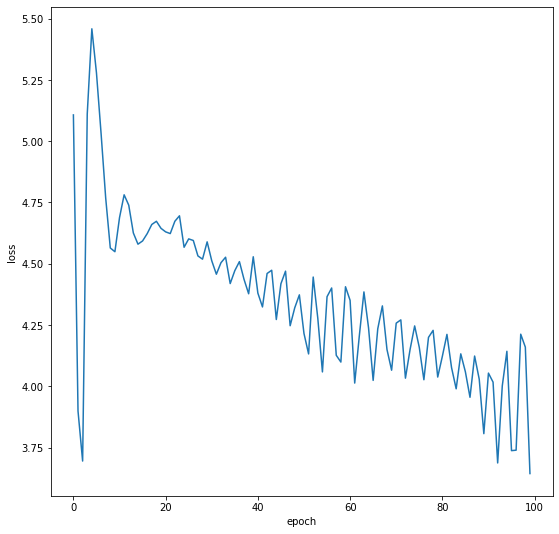

In [17]:
plt.figure(figsize=(9, 9))
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss');

### Inference

In [18]:
model = model.to(device)
cohort_embeddings = []
for sample_data_object in tqdm(cohort_graph_dataset):
    sample_id = sample_data_object.sample_id
    image_roi = sample_data_object.image_roi
    with torch.no_grad():
        model.eval()
        x, edge_index = (sample_data_object.x.to(device), 
                         sample_data_object.edge_index.to(device))

        z = model.encode(x, edge_index)
        z = z.squeeze()
        z = z.detach().cpu().numpy()

    node_embeddings = pd.DataFrame(z)
    node_embeddings['sample_id'] = sample_id
    node_embeddings['image_roi'] = image_roi
    node_embeddings['cell_index'] = sample_data_object.contour_index
    cohort_embeddings.append(node_embeddings)
    
cohort_embeddings = pd.concat(cohort_embeddings)
cohort_embeddings = cohort_embeddings.reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]

## Cluster embeding

In [19]:
clusterer = MiniBatchKMeans(n_clusters=n_communities, random_state=random_state)
embedding_clusters = clusterer.fit_predict(cohort_embeddings[list(range(features_num))].values)
embedding_clusters = pd.Series(embedding_clusters, name='graph_cluster')
embedding_clusters = 'cluster_' + embedding_clusters.apply(str)
cohort_embeddings['graph_cluster'] = embedding_clusters
if save_inference is not None:
    cohort_embeddings.to_csv(save_inference, index=False)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f05713be3a0>
Traceback (most recent call last):
  File "/home/avarlamova/torch_38/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/avarlamova/torch_38/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/avarlamova/torch_38/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/avarlamova/torch_38/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
